In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Описание задания

В базе данных нефтегазовых месторождений одной компании произошёл системный сбой и информация о типе месторождения по расположению (на берегу или в открытом море) была удалена. 

Так как эта информация крайне важна, вам необходимо восстановить её в пострадавшем датасете (https://yadi.sk/d/oTXS7UAIu2OJOg). 
*Дополнительная ссылка для скачивания*: `test.csv`

В качестве тренировочного датасета можете использовать неиспорченный датасет (https://yadi.sk/d/MmT-_fY6sKzlTmw).

*Дополнительная ссылка для скачивания* `train.csv`

**Входные данные**: тренировочный датасет `train.csv`, в котором поля обозначают следующее:

1. `Tectonic regime` – тектонический режим месторождения
2. `Onshore/Oﬀshore` - (`целевая переменная` $y$) – тип месторождения по расположению
3. `Hydrocarbon type` – тип углеводородов
4. `Reservoir status` – статус разработки месторождения
5. `Structural setting` – структурные особенности месторождения
6. `Depth` – средняя глубина кровли резервуара
7. `Period` – геологическая система образования резервуара
8. `Lithology` – основной литологический состав коллектора
9. `Gross` – среднее значение общей толщины резервуара
10. `Netpay` – среднее значение эффективной углеводородонасыщенной толщины коллектора
11. `Porosity` – среднее значение матричной пористости
12. `Permeability` – среднее значение проницаемости по воздуху.

`test.csv` – датасет, для которого необходимо предсказать поле `Onshore/Oﬀshore`.

**Выходные данные**: файл `prediction.csv`, в котором одна колонка (`без заголовка`) с предсказанием поля `Onshore/Oﬀshore`. 

Предсказания следует выводить в тех же значениях, в каких они представлены в тренировочном датасете:

- (`ONSHORE`/`OFFSHORE`/ `ONSHORE-OFFSHORE`).

**Критерии проверки**: вычисляется точность предсказания (`accuracy_score`), округляется до `2`-х знаков и итоговый балл считается по формуле `score = 50 * accuracy_score`. Таким образом максимальный балл `50` будет соответствовать максимально точности `1`.

## 1. Explore Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,Tectonic regime,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Period,Lithology,Gross,Netpay,Porosity,Permeability
0,STRIKE-SLIP/TRANSPRESSION/BASEMENT-I,OFFSHORE,OIL,DEVELOPING,INVERSION/WRENCH,3520,NEOGENE,SANDSTONE,2460.0,220.0,20.0,45.0
1,GRAVITY/EXTENSION/EVAPORITE,OFFSHORE,OIL,MATURE PRODUCTION,SALT/PASSIVE MARGIN,9967,CRETACEOUS,LIMESTONE,427.0,160.0,19.0,175.0
2,GRAVITY/EXTENSION/EVAPORITE,ONSHORE,OIL,MATURE PRODUCTION,PASSIVE MARGIN,8700,CRETACEOUS,LIMESTONE,95.0,15.0,12.0,20.0
3,COMPRESSION,ONSHORE,OIL,DECLINING PRODUCTION,THRUST,5084,CRETACEOUS,SANDSTONE,328.0,300.0,13.0,600.0
4,INVERSION/COMPRESSION/EXTENSION,ONSHORE,OIL,DECLINING PRODUCTION,INVERSION/RIFT,1030,CRETACEOUS,SANDSTONE,260.0,33.0,24.0,182.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Tectonic regime     309 non-null    object 
 1   Onshore/Offshore    309 non-null    object 
 2   Hydrocarbon type    309 non-null    object 
 3   Reservoir status    309 non-null    object 
 4   Structural setting  309 non-null    object 
 5   Depth               309 non-null    int64  
 6   Period              309 non-null    object 
 7   Lithology           309 non-null    object 
 8   Gross               309 non-null    float64
 9   Netpay              309 non-null    float64
 10  Porosity            309 non-null    float64
 11  Permeability        309 non-null    float64
dtypes: float64(4), int64(1), object(7)
memory usage: 29.1+ KB


In [5]:
train.describe()

,Depth,Gross,Netpay,Porosity,Permeability
count,309.000000,309.000000,309.000000,309.000000,309.000000
mean,6726.242718,798.440129,204.166084,17.929709,463.048544
std,3506.266685,1329.172384,285.145971,7.644533,981.882456
min,220.000000,11.000000,0.000000,1.300000,0.010000
25%,3940.000000,145.000000,46.000000,12.000000,10.000000
50%,6580.000000,353.000000,118.000000,17.000000,90.000000
75%,9327.000000,790.000000,240.000000,24.000000,450.000000
max,18050.000000,10500.000000,2976.000000,55.000000,7500.000000


## 1.1 `Tectonic regime` - тектонический режим месторождения

Сначала разобьем строки по символу `/`, затем найдем уникальные тектонические режимы и составим таблицу признаков для первого столбца.

In [6]:
values= {}
l_of_list = train['Tectonic regime'].str.split('/').tolist() # partition 
for i in l_of_list:
    for j in i:
        if j in values.keys():
            values[j] += 1
        else:
            values[j] = 0
            values[j] +=1

In [7]:
X_Tectonic_regime = pd.DataFrame(data = np.zeros((train.shape[0], 
                                                  len(values.keys()))), 
                                 columns=values.keys())
for i, val in zip(range(train.shape[0]), l_of_list):
    for j in val:
        X_Tectonic_regime.at[i, j] = 1

In [8]:
X_Tectonic_regime_2 = pd.DataFrame(data = np.zeros((train.shape[0], 
                                                  len(values.keys()))), 
                                 columns=values.keys())
for i, val in zip(range(train.shape[0]), l_of_list):
    for j in val:
        X_Tectonf = values[j] / np.sum(list(values.values()))

## 1.2 `Onshore/Oﬀshore` - тип месторождения по расположению

Является целевой переменной - переведем в числовой тип.

In [9]:
y = train['Onshore/Offshore'].map({'OFFSHORE': 0, 
                               'ONSHORE': 1, 
                               'ONSHORE-OFFSHORE': 2}).values.astype(int)

In [10]:
pd.value_counts(y)

1    211
0     93
2      5
dtype: int64

In [11]:
y

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,

## 1.3 `Hydrocarbon type` -  тип углеводородов

In [12]:
pd.value_counts(train['Hydrocarbon type'])

OIL                235
GAS                 47
GAS-CONDENSATE      25
METHANE HYDRATE      1
CARBON DIOXIDE       1
Name: Hydrocarbon type, dtype: int64

In [13]:
pd.unique(train['Hydrocarbon type'])

array(['OIL', 'METHANE HYDRATE', 'GAS', 'GAS-CONDENSATE',
       'CARBON DIOXIDE'], dtype=object)

Попробуем несколько методов работы с категориальными переменными:

- `LabelEncoder`
- `OneHotEncoder`

### 1.3.1 - `OneHotEncoder`

In [14]:
X_hydrocarbon_onehotencoder = pd.get_dummies(train['Hydrocarbon type'])
X_hydrocarbon_onehotencoder

,CARBON DIOXIDE,GAS,GAS-CONDENSATE,METHANE HYDRATE,OIL
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
304,0,0,0,0,1
305,0,0,0,0,1
306,0,0,0,0,1
307,0,0,1,0,0


## 1.3.2 `LabelEncoder`

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [16]:
X_hydrocarbon_labelencoder = LabelEncoder().fit_transform(train['Hydrocarbon type'].values)
X_hydrocarbon_labelencoder

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 1, 4, 4, 4, 4, 4, 2, 1, 4, 4,
       4, 2, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4,
       1, 4, 4, 4, 1, 4, 4, 1, 4, 4, 4, 2, 1, 4, 4, 1, 2, 4, 4, 4, 4, 4,
       2, 4, 4, 4, 1, 4, 4, 2, 4, 4, 1, 4, 4, 4, 1, 1, 4, 1, 4, 1, 4, 1,
       4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 1, 4, 4, 4, 4, 2,
       4, 4, 2, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 1, 0, 4, 1, 4, 4, 4, 4,
       4, 1, 4, 4, 1, 2, 4, 1, 4, 4, 4, 4, 4, 4, 4, 1, 4, 1, 4, 1, 4, 4,
       4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 1, 4, 1, 4, 4, 4, 2, 1,
       4, 1, 4, 4, 4, 1, 4, 4, 1, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 1, 4, 1, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 2, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 2, 4, 1, 1, 4, 4, 4,
       4, 1, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 1, 4, 4, 4, 4, 4, 2,
       4, 4, 4, 1, 1, 4, 4, 2, 1, 4, 1, 4, 4, 4, 4,

## 1.4 `Reservoir status` - статус разработки месторождения

In [17]:
pd.unique(train['Reservoir status'])

array(['DEVELOPING', 'MATURE PRODUCTION', 'DECLINING PRODUCTION',
       'REJUVENATING', 'ABANDONED', 'NEARLY DEPLETED', 'UNKNOWN',
       'PLATEAU PRODUCTION', 'UNDEVELOPED', 'CONTINUING DEVELOPMENT',
       'SECOND PLATEAU PRODUTION', 'DEPLETED'], dtype=object)

In [18]:
pd.value_counts(train['Reservoir status'])

DECLINING PRODUCTION        93
MATURE PRODUCTION           55
NEARLY DEPLETED             52
PLATEAU PRODUCTION          32
REJUVENATING                21
DEVELOPING                  21
UNKNOWN                     12
UNDEVELOPED                  7
CONTINUING DEVELOPMENT       6
SECOND PLATEAU PRODUTION     5
ABANDONED                    4
DEPLETED                     1
Name: Reservoir status, dtype: int64

## 1.5 `Structural setting`

In [19]:
values_structural_setting = {}
l_of_list_str_sett = train['Structural setting'].str.split('/').tolist() # partition 
for i in l_of_list_str_sett:
    for j in i:
        if j in values_structural_setting.keys():
            values_structural_setting[j] += 1
        else:
            values_structural_setting[j] = 0
            values_structural_setting[j] +=1
X_structural_setting = pd.DataFrame(data = np.zeros((train.shape[0], 
                                                  len(values_structural_setting.keys()))), 
                                 columns=values_structural_setting.keys(), dtype=int)
for i, val in zip(range(train.shape[0]), l_of_list_str_sett):
    for j in val:
        X_structural_setting.at[i, j] = 1

In [20]:
X_structural_setting

,INVERSION,WRENCH,SALT,PASSIVE MARGIN,THRUST,RIFT,INTRACRATONIC,FORELAND,DELTA,SUB-THRUST,SUB-SALT,BACKARC,,FOREARC
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,0,0,0,1,0,0,0,0,1,0,1,0,0,0
305,0,0,0,1,0,1,0,0,0,0,0,0,0,0
306,0,0,0,0,0,0,0,1,0,0,0,0,0,0
307,0,0,1,0,0,1,0,0,0,0,0,0,0,0


## 1.6 `Depth` – средняя глубина кровли резервуара

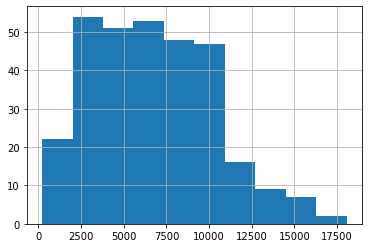

In [21]:
train['Depth'].hist()

Можно применить `MinMaxScaler`

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [23]:
standart_scaler_depth = StandardScaler().fit_transform(train['Depth'].values.reshape(-1, 1))

In [24]:
min_max_scaler_depth =  MinMaxScaler().fit_transform(train['Depth'].values.reshape(-1, 1))

## 1.7 `Period` - геологическая система образования резервуара

In [25]:
pd.unique(train['Period'])

array(['NEOGENE', 'CRETACEOUS', 'CARBONIFEROUS', 'PROTEROZOIC', 'PERMIAN',
       'PALEOGENE-NEOGENE', 'DEVONIAN', 'JURASSIC', 'PALEOGENE',
       'CARBONIFEROUS-PERMIAN', 'CRETACEOUS-PALEOGENE', 'ORDOVICIAN',
       'TRIASSIC', 'PROTEROZOIC-CAMBRIAN', 'TRIASSIC-JURASSIC',
       'JURASSIC-CRETACEOUS', 'CARBONIFEROUS-CRETACEOUS', 'ARCHEAN',
       'CAMBRIAN', 'MESOZOIC', 'CAMBRIAN-ORDOVICIAN', 'PALEOZOIC'],
      dtype=object)

In [26]:
pd.value_counts(train['Period'])

CRETACEOUS                  83
NEOGENE                     45
JURASSIC                    41
PALEOGENE                   34
CARBONIFEROUS               25
PERMIAN                     22
DEVONIAN                    16
TRIASSIC                    10
CRETACEOUS-PALEOGENE         8
PROTEROZOIC                  5
CARBONIFEROUS-PERMIAN        4
PALEOGENE-NEOGENE            3
TRIASSIC-JURASSIC            2
JURASSIC-CRETACEOUS          2
ORDOVICIAN                   2
CAMBRIAN                     1
MESOZOIC                     1
ARCHEAN                      1
CAMBRIAN-ORDOVICIAN          1
PALEOZOIC                    1
CARBONIFEROUS-CRETACEOUS     1
PROTEROZOIC-CAMBRIAN         1
Name: Period, dtype: int64

In [27]:
X_period = LabelEncoder().fit_transform(train['Period'].values)
X_period

array([12,  6,  6,  6,  6,  3, 18,  6,  3, 17,  6, 15,  8, 12,  6,  9, 12,
        6,  3,  3,  9, 17, 12,  9,  9, 17,  3, 14,  9,  6,  5,  7, 12,  8,
        8,  9,  9,  6, 12,  8, 17,  6,  6,  9, 13,  6, 12,  8,  8, 12,  6,
        3, 20,  9,  6, 14,  9,  9,  6, 17,  6, 19, 14,  9,  3,  6, 14, 14,
        6,  9, 12, 14, 17, 21,  6,  9,  6,  5, 12,  9,  6,  6,  9, 10, 20,
        8,  8,  8,  6,  6,  9,  6,  3, 12,  3, 15,  6,  9,  6,  8, 14,  8,
        6, 14,  8,  3,  6, 12, 12, 18,  6,  6, 10,  9,  6,  8,  9,  4, 12,
        7,  3, 12,  6,  3,  9, 12, 12,  3, 17, 17,  0, 12, 21,  6,  6, 14,
        6,  6,  6,  3, 12, 17, 12, 20,  9,  6,  7, 17, 14, 18, 17, 14, 14,
        6,  9, 12, 14,  3,  9,  3,  9, 20, 12,  9,  6, 12,  3,  6, 17, 12,
        9,  6,  5,  9,  6, 13, 12, 20, 17,  6, 18,  6, 14,  6, 14,  6, 14,
       14,  6,  1,  6,  6,  9,  9, 12, 12,  3,  6,  3,  9,  6, 12, 14,  6,
        6, 12,  7,  6, 17, 18, 14, 12, 12,  3, 12, 12,  6, 17,  6,  9,  9,
        6,  6,  8, 12, 12

## 1.8  `Lithology` - основной литологический состав коллектора

In [28]:
pd.value_counts(train['Lithology'])

SANDSTONE                    180
LIMESTONE                     42
DOLOMITE                      38
LOW-RESISTIVITY SANDSTONE      9
CONGLOMERATE                   7
CHALK                          7
CHALKY LIMESTONE               6
THINLY-BEDDED SANDSTONE        6
SILTSTONE                      3
SHALY SANDSTONE                3
DOLOMITIC LIMESTONE            2
VOLCANICS                      2
SHALE                          1
DIATOMITE                      1
BASEMENT                       1
CHERT                          1
Name: Lithology, dtype: int64

In [29]:
map_dict = pd.value_counts(train['Lithology']) / (pd.value_counts(train['Lithology']).sum())

In [30]:
X_Lithology = train['Lithology'].map(map_dict).to_frame()
X_Lithology

,Lithology
0,0.582524
1,0.135922
2,0.135922
3,0.582524
4,0.582524
...,...
304,0.029126
305,0.029126
306,0.019417
307,0.582524


In [31]:
X_Lithology_label_encoder = LabelEncoder().fit_transform(train['Lithology'].values)
X_Lithology_label_encoder

array([10,  8,  8, 10, 10,  6, 10, 10,  8,  6, 10, 10,  6, 10, 10, 10, 10,
       10,  6,  8, 10, 10, 10, 10, 14,  6,  8, 10,  8,  2,  8,  8, 10,  8,
        8, 10, 10, 10, 10,  6,  6,  9,  8, 10,  6,  9, 10,  3, 11, 10, 10,
        4, 10,  8, 10, 10, 10, 10,  8, 10, 10,  6, 10,  6,  6, 10, 12,  8,
       10, 10, 10, 10,  6, 10, 12,  8,  8,  8, 10, 10,  8, 10,  8, 10,  4,
        6, 10,  6,  1, 10,  8, 13,  6, 10, 10,  7, 10,  8,  8, 10, 10,  6,
       10, 10,  6,  6,  2, 10,  5, 10,  6, 10, 10, 10, 10, 10,  8, 10, 10,
       10,  7, 10, 10, 10,  2,  8, 10,  4,  6,  8,  0, 10, 10, 10, 10, 10,
       10,  8, 10, 12, 10,  8,  9, 10, 10, 10,  1,  6, 10, 10,  6, 10,  8,
       10, 10, 10, 10,  6, 10,  6, 10, 10, 10, 10, 10,  8,  6,  8, 10,  8,
        6, 10, 10,  6, 10, 10, 10, 10,  6, 10,  6, 10, 10,  8, 10,  9, 10,
       10,  9, 10, 10, 10, 10, 10, 14, 14,  8,  9, 10, 10, 10, 10, 10,  8,
        8, 10, 10,  9, 13,  6, 10, 10, 10,  8, 10, 10, 10,  6, 10, 10, 10,
       10, 10,  6, 10, 10

## 1.9 `Gross` – среднее значение общей толщины резервуара

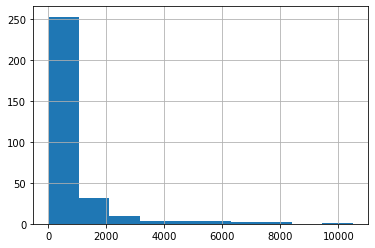

In [32]:
train['Gross'].hist()
plt.show()

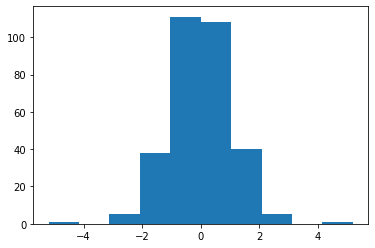

In [33]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal', n_quantiles=train.shape[0])
X_normal_gross = qt.fit_transform(train['Gross'].values.reshape(-1, 1))
plt.hist(X_normal_gross)
plt.show()

## 1.10 `Netpay` – среднее значение эффективной углеводородонасыщенной толщины коллектора

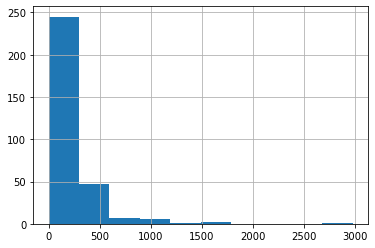

In [34]:
train['Netpay'].hist()
plt.show()

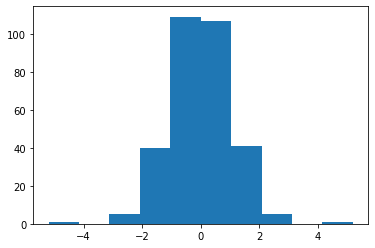

In [35]:
X_normal_netpay = qt.fit_transform(train['Netpay'].values.reshape(-1, 1))
plt.hist(X_normal_netpay)
plt.show()

## 1.11 `Porosity` - среднее значение матричной пористости

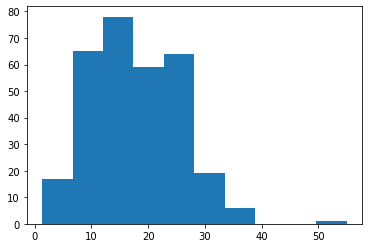

In [36]:
plt.hist(train['Porosity'])
plt.show()

## 1.12 `Permeability` – среднее значение проницаемости по воздуху.

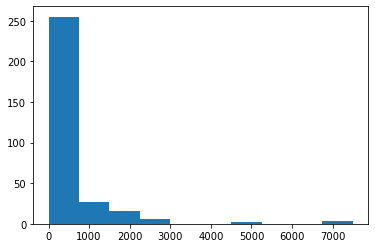

In [37]:
plt.hist(train['Permeability'])
plt.show()

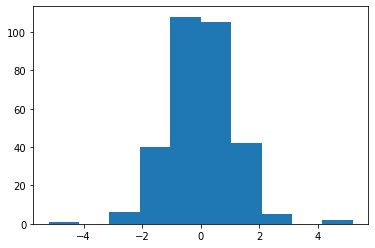

In [38]:
X_normal_Permeability = qt.fit_transform(train['Permeability'].values.reshape(-1, 1))
plt.hist(X_normal_Permeability)
plt.show()

## 2. Features

In [39]:
X_features = pd.concat((X_Tectonic_regime, 
           X_hydrocarbon_onehotencoder, 
           X_structural_setting, 
           train['Depth'],
           pd.DataFrame(X_period, columns=['Period']),
           X_Lithology, 
           pd.DataFrame(X_normal_gross, columns=['Gross']), 
           pd.DataFrame(X_normal_netpay, columns=['Netpay']), 
           train['Porosity'], 
           pd.DataFrame(X_normal_Permeability, columns=['Permeability'])), axis=1)

In [40]:
X_features.shape

(309, 42)

In [41]:
X_features = pd.concat((X_Tectonic_regime, 
                        X_hydrocarbon_onehotencoder, 
                        #pd.DataFrame(X_hydrocarbon_labelencoder, columns=['hydrocarbon']),
                        X_structural_setting, 
                        train['Depth'],
                        #pd.DataFrame(MinMaxScaler().fit_transform(train['Depth'].values.reshape(-1, 1)), columns=['Depth']),
                        pd.DataFrame(X_period, columns=['Period']),
                        #X_Lithology, 
                        #pd.DataFrame(LabelEncoder().fit_transform(train['Reservoir status']), columns=['Reservoir status']),
                        pd.DataFrame(X_Lithology_label_encoder, columns=['Lithology']),
                        pd.DataFrame(StandardScaler().fit_transform(train['Gross'].values.reshape(-1, 1)), columns=['Gross']),
                        #train['Gross'],
                        pd.DataFrame(X_normal_gross, columns=['Gross']), 
                        #train['Netpay'],
                        pd.DataFrame(X_normal_netpay, columns=['Netpay']), 
                        #pd.DataFrame(StandardScaler().fit_transform(train['Porosity'].values.reshape(-1, 1)), columns=['Porosity']),
                        #train['Permeability']
                        pd.DataFrame(X_normal_Permeability, columns=['Permeability'])
                      ), 
                       axis=1)

## 3. Cross Validation

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [43]:
adb = AdaBoostClassifier(base_estimator=ExtraTreesClassifier(n_estimators = 400, max_features=10, random_state=42),
                           n_estimators=400, random_state=1)

adb_max_features = AdaBoostClassifier(base_estimator=RandomForestClassifier(),
                           n_estimators=400, random_state=1)

# lgb_classifier = lgb.LGBMClassifier(num_leaves=400, 
#                               learning_rate=0.01, 
#                               n_estimators=int(400),
#                               colsample_bytree=0.5,
#                               subsample=0.5, 
#                               nthread=-1,
#                               random_state=42)

gb = GradientBoostingClassifier(n_estimators=400, 
                                     subsample=0.5,
                                     max_features=4,
                                     random_state=42)
cv = ShuffleSplit(n_splits=3, test_size=0.25)
kf = KFold(n_splits=4, shuffle=True)
classifiers = []

# метод split возвращает индексы для объектов train и test
for train_index, test_index in kf.split(X_features):
    vote_classifier = VotingClassifier([('ADB(10)', adb), 
                                    ('ADB', adb_max_features), 
                                    #('LGB', lgb_classifier), 
                                    ('GB', gb)])
    X_train, X_test = X_features.iloc[train_index], X_features.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    vote_classifier.fit(X_train, y_train)
    print(accuracy_score(vote_classifier.predict(X_test), y_test))
 
    # получим 5 оптимальных классификаторов
    classifiers.append(vote_classifier)

## Test Another Features

## Test Features Prepare

In [43]:
test = pd.read_csv('test.csv')
test

,Tectonic regime,Hydrocarbon type,Reservoir status,Structural setting,Depth,Period,Lithology,Gross,Netpay,Porosity,Permeability
0,COMPRESSION,GAS,MATURE PRODUCTION,FORELAND,2275,PERMIAN,SANDSTONE,325.0,30.0,13.0,0.04
1,INVERSION/COMPRESSION/EXTENSION/EROSION,OIL,ABANDONED,FORELAND,500,PERMIAN,SANDSTONE,40.0,18.0,28.0,240.00
2,INVERSION/COMPRESSION/EXTENSION/EVAPORITE,GAS,DECLINING PRODUCTION,INVERSION/RIFT,5548,JURASSIC,DOLOMITE,200.0,20.0,13.0,7.30
3,COMPRESSION/EVAPORITE/EXTENSION/LINKED,OIL,DEVELOPING,THRUST,10100,NEOGENE,SANDSTONE,8200.0,260.0,18.0,100.00
4,COMPRESSION/EROSION,GAS-CONDENSATE,MATURE PRODUCTION,FORELAND,8750,CARBONIFEROUS,DOLOMITE,140.0,70.0,12.0,125.00
...,...,...,...,...,...,...,...,...,...,...,...
128,EXTENSION/EROSION,OIL,DECLINING PRODUCTION,RIFT,5520,TRIASSIC-JURASSIC,SANDSTONE,630.0,394.0,26.0,1000.00
129,COMPRESSION/EROSION,BITUMEN,CONTINUING DEVELOPMENT,FORELAND,1500,CRETACEOUS,SANDSTONE,100.0,82.0,28.0,440.00
130,COMPRESSION/STRIKE-SLIP/TRANSPRESSION/BASEMENT-I,OIL,NEARLY DEPLETED,WRENCH/FOREARC,11100,NEOGENE,THINLY-BEDDED SANDSTONE,200.0,150.0,20.0,75.00
131,INVERSION/COMPRESSION/EXTENSION,OIL,SECOND PLATEAU PRODUTION,RIFT/INVERSION,3939,PALEOGENE,SANDSTONE,410.0,20.0,28.0,1000.00


In [44]:
values_test= {}
l_of_list_test = test['Tectonic regime'].str.split('/').tolist() # partition 
for i in l_of_list_test:
    for j in i:
        if j in values_test.keys():
            values_test[j] += 1
        else:
            values_test[j] = 0
            values_test[j] +=1

In [45]:
X_Tectonic_test = pd.DataFrame(data = np.zeros((test.shape[0], 
                                                  len(values.keys()))), 
                                 columns=values.keys())
X_Tectonic_test

,STRIKE-SLIP,TRANSPRESSION,BASEMENT-I,GRAVITY,EXTENSION,EVAPORITE,COMPRESSION,INVERSION,EROSION,LINKED,DIAPIR,SYNSEDIMENTATION,SHALE,TRANSTENSION,REACTIVATION,UPLIFT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
for i, val in zip(range(test.shape[0]), l_of_list_test):
    for j in val:
        X_Tectonic_test.at[i, j] = 1

In [47]:
X_Tectonic_test

,STRIKE-SLIP,TRANSPRESSION,BASEMENT-I,GRAVITY,EXTENSION,EVAPORITE,COMPRESSION,INVERSION,EROSION,LINKED,DIAPIR,SYNSEDIMENTATION,SHALE,TRANSTENSION,REACTIVATION,UPLIFT
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
X_hydrocarbon_onehotencoder_test = pd.get_dummies(test['Hydrocarbon type'])
X_hydrocarbon_onehotencoder_test

,BITUMEN,CARBON DIOXIDE,GAS,GAS-CONDENSATE,OIL
0,0,0,1,0,0
1,0,0,0,0,1
2,0,0,1,0,0
3,0,0,0,0,1
4,0,0,0,1,0
...,...,...,...,...,...
128,0,0,0,0,1
129,1,0,0,0,0
130,0,0,0,0,1
131,0,0,0,0,1


In [49]:
X_test_features = pd.concat((X_Tectonic_test, X_hydrocarbon_onehotencoder_test), axis=1)
X_test_features.shape

(133, 21)

In [50]:
X_features = pd.concat((X_Tectonic_regime, 
                        X_hydrocarbon_onehotencoder, 
                        X_structural_setting, 
                        train['Depth'],
                        pd.DataFrame(X_period, columns=['Period']),
                        pd.DataFrame(X_Lithology_label_encoder, columns=['Lithology']),
                        pd.DataFrame(StandardScaler().fit_transform(train['Gross'].values.reshape(-1, 1)), columns=['Gross']),
                        pd.DataFrame(X_normal_gross, columns=['Gross']), 
                        pd.DataFrame(X_normal_netpay, columns=['Netpay']), 
                        pd.DataFrame(X_normal_Permeability, columns=['Permeability'])), axis=1)

In [51]:
l_of_list_str_sett_test = test['Structural setting'].str.split('/').tolist() # partition
X_structural_setting_test = pd.DataFrame(data = np.zeros((test.shape[0], 
                                                  len(values_structural_setting.keys()))), 
                                 columns=values_structural_setting.keys(), dtype=int)
for i, val in zip(range(test.shape[0]), l_of_list_str_sett_test):
    for j in val:
        X_structural_setting_test.at[i, j] = 1

In [52]:
from sklearn.preprocessing import QuantileTransformer
qtt = QuantileTransformer(output_distribution='normal', n_quantiles=test.shape[0])
X_normal_gross_test = qtt.fit_transform(test['Gross'].values.reshape(-1, 1))
X_normal_netpay_test = qtt.fit_transform(test['Netpay'].values.reshape(-1, 1))
X_normal_perm_test = qtt.fit_transform(test['Permeability'].values.reshape(-1, 1))

In [53]:
X_test_features = pd.concat((X_Tectonic_test, 
                             X_hydrocarbon_onehotencoder_test, 
                             X_structural_setting_test, 
                             test['Depth'],
                             pd.DataFrame(LabelEncoder().fit_transform(test['Period']), columns=['Period']),
                             pd.DataFrame(LabelEncoder().fit_transform(test['Lithology']), columns=['Lithology']),
                             pd.DataFrame(StandardScaler().fit_transform(test['Gross'].values.reshape(-1, 1)), columns=['Gross']),
                             pd.DataFrame(X_normal_gross_test, columns=['Gross']), 
                             pd.DataFrame(X_normal_netpay_test, columns=['Netpay']), 
                             pd.DataFrame(X_normal_perm_test, columns=['Permeability'])), axis=1)
X_test_features.shape

(133, 42)

In [54]:
X_features.shape

(309, 42)

## Submission

In [55]:
X_features = pd.concat((X_Tectonic_regime, 
                        X_hydrocarbon_onehotencoder, 
                        #pd.DataFrame(X_hydrocarbon_labelencoder, columns=['hydrocarbon']),
                        X_structural_setting, 
                        train['Depth'],
                        #pd.DataFrame(MinMaxScaler().fit_transform(train['Depth'].values.reshape(-1, 1)), columns=['Depth']),
                        pd.DataFrame(X_period, columns=['Period']),
                        #X_Lithology, 
                        #pd.DataFrame(LabelEncoder().fit_transform(train['Reservoir status']), columns=['Reservoir status']),
                        pd.DataFrame(X_Lithology_label_encoder, columns=['Lithology']),
                        pd.DataFrame(StandardScaler().fit_transform(train['Gross'].values.reshape(-1, 1)), columns=['Gross']),
                        #train['Gross'],
                        pd.DataFrame(X_normal_gross, columns=['Gross']), 
                        #train['Netpay'],
                        pd.DataFrame(X_normal_netpay, columns=['Netpay']), 
                        #pd.DataFrame(StandardScaler().fit_transform(train['Porosity'].values.reshape(-1, 1)), columns=['Porosity']),
                        #train['Permeability']
                        pd.DataFrame(X_normal_Permeability, columns=['Permeability'])
                      ), 
                       axis=1)

In [63]:
adb = AdaBoostClassifier(base_estimator=ExtraTreesClassifier(n_estimators = 800, max_features=10, random_state=42),
                           n_estimators=800, random_state=1)

adb_max_features = AdaBoostClassifier(base_estimator=ExtraTreesClassifier(n_estimators = 800,  random_state=42),
                           n_estimators=800, random_state=1)

gb = GradientBoostingClassifier(n_estimators=800, 
                                     subsample=0.5,
                                     max_features=4,
                                     random_state=42)
cv = ShuffleSplit(n_splits=3, test_size=0.25)


In [64]:
inv_map = {0 : 'OFFSHORE', 1: 'ONSHORE', 2: 'ONSHORE-OFFSHORE'}

In [ ]:
kf = KFold(n_splits=5, shuffle=True)
for i in range(8):
    # метод split возвращает индексы для объектов train и test
    acc = []
    classifiers = []
    for train_index, test_index in kf.split(X_features):
        vote_classifier = VotingClassifier([('ADB(10)', adb), 
                                    ('ADB', adb_max_features), 
                                    #('LGB', lgb_classifier), 
                                    ('GB', gb)])
        X_train, X_test = X_features.iloc[train_index], X_features.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        vote_classifier.fit(X_train, y_train)
        acc.append(accuracy_score(vote_classifier.predict(X_test), y_test))
 
        # получим 5 оптимальных классификаторов
        classifiers.append(vote_classifier)
    print(f'iteration {i}, acc: {np.mean(acc)}')
    res = []
    for c in classifiers:
        res.append(c.predict(X_test_features))
        
    result_vote = pd.DataFrame(np.array(res).T)
    (
        np.round(result_vote.sum(axis=1) / result_vote.count(axis=1))
        .astype(int)
    ).map(inv_map).to_csv(f'sub/sub_{i}.csv', 
                          index=False, 
                          header=0)

iteration 0, acc: 0.870597567424643
iteration 1, acc: 0.8384452670544686
iteration 2, acc: 0.8544156530936012
iteration 3, acc: 0.8544156530936012
iteration 4, acc: 0.8315705975674247
iteration 5, acc: 0.8350608143839239


In [151]:
for i in range(8):
    # метод split возвращает индексы для объектов train и test
    acc = []
    classifiers = []
    for train_index, test_index in kf.split(X_features):
        vote_classifier = VotingClassifier([('ADB(10)', adb), 
                                    ('ADB', adb_max_features), 
                                    #('LGB', lgb_classifier), 
                                    ('GB', gb)])
        X_train, X_test = X_features.iloc[train_index], X_features.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        vote_classifier.fit(X_train, y_train)
        acc.append(accuracy_score(vote_classifier.predict(X_test), y_test))
 
        # получим 5 оптимальных классификаторов
        classifiers.append(vote_classifier)
    print(f'iteration {i}, acc: {np.mean(acc)}')
    res = []
    for c in classifiers:
        res.append(c.predict(X_test_features))
        
    result_vote = pd.DataFrame(np.array(res).T)
    (
        np.round(result_vote.sum(axis=1) / result_vote.count(axis=1))
        .astype(int)
    ).map(inv_map).to_csv(f'submission/sub_{i}.csv', 
                          index=False, 
                          header=0)

iteration 0, acc: 0.8318878900052882
iteration 1, acc: 0.8024854574299314
iteration 2, acc: 0.8381808566895822
iteration 3, acc: 0.8351665785298785
iteration 4, acc: 0.8480169222633528
iteration 5, acc: 0.8416710735060814
iteration 6, acc: 0.8479640401903754
iteration 7, acc: 0.818667371760973
